# Notebook Overview
This notebook contains the full pipeline used to train a U-Net model for image segmentation. It includes the implementation of multiple loss functions (Dice loss was the chosen loss function for the final model), as well as data augmentation techniques to enhance generalization.
The training cell was intentionally interrupted before submission, as it was only re-run to verify that the code executes correctly. In the testing section, the best-performing model ("Most_best.pth"/ResNet-18 encoder) is loaded to demonstrate qualitative results on a set of 20 images.

Training was performed using a GPU, while testing was carried out on a CPU.

In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torchinfo import summary
import math
import re
import torchvision.transforms.functional as TF

# Imports

In [3]:
!pip install segmentation-models-pytorch --quiet
!pip install matplotlib

In [4]:
import segmentation_models_pytorch as smp

# Dataset and Pre-processing

In [5]:
#Pre-process data: applying transforms and data augmentation before entering network

class Pre_process:
    def augment_Data(self, img, mask):
        #50% chance of horizontal flip (every other image frame)
        if torch.rand(1).item() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        #always applying a small rotation -+15
        angle = torch.randint(-15, 15, (1,)).item()
        img = TF.rotate(img, angle)
        mask = TF.rotate(mask, angle)
        return img, mask


#Resizing + Grayscale
def base_transform(image, is_mask=False):
    transform = transforms.Compose([
        transforms.Resize((256, 320)),
        transforms.Grayscale(num_output_channels=3 if not is_mask else 1),
        transforms.ToTensor()
    ])
    return transform(image)


In [6]:
#Creating dataset
class Primate_segmen_Dataset(Dataset):
    def __init__(self, img_paths, mask_paths, augment=False):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        assert len(self.img_paths) == len(self.mask_paths), "ERROR image number and mask number do not match!"
        
        self.augment = augment
        self.augmentation = Pre_process() if augment else None

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx] 
        mask_path = self.mask_paths[idx] 

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        #Apply base_transformations
        img = base_transform(img, is_mask=False)
        mask= base_transform(mask, is_mask=True)

        #Apply on-the-fly augmentation only to training data
        if self.augment:
            img, mask = self.augmentation.augment_Data(img, mask)

        return img, mask


In [33]:
#To make sure the frame and mask index matches
#not using global sort as that doesn't guarantee
#e.g. this doesn't work:sorted(glob.glob(os.path.join(images_folder, "*.png")))

def extract_frame_id(filename):
    #removes the _BIN suffix and png suffix so that it can match
    #just the FLIR_Number + frame number
    #removse hidden spaces
    basename = os.path.basename(filename).strip()  
    frame_id = basename.replace("_BIN.png", "").replace(".png", "")
    frame_id = re.sub(r"(FLIR\d+)[A-Z]?_(\d+)", r"\1_\2", frame_id)  
    frame_id = frame_id.rstrip("_")
    return frame_id

#Paths to data
images_folder = "/kaggle/input/training-frames/frames total" 
masks_folder = "/kaggle/input/training-masks/masks binary total"

#Get all the files from the paths
image_files = glob.glob(os.path.join(images_folder, "*.png"))
mask_files = glob.glob(os.path.join(masks_folder, "*.png"))

#Create a dictionary with the frame index: VIDEO_name + Frame name
#e.g. FLIR1004_200
#Stores all image indexes
image_dict = {extract_frame_id(img): img for img in image_files}
#Stores all mask indexes
mask_dict = {extract_frame_id(mask): mask for mask in mask_files}

#Loops through all the images
#if it has a corresponding mask pair (all should)
#it stores it as a tuple in a list (image, image's mask)
matched_pairs = [(image_dict[k], mask_dict[k]) for k in image_dict if k in mask_dict]
#missing_masks = [img_id for img_id in image_dict if img_id not in mask_dict]
#print(f"Missing Masks: {len(missing_masks)} files don't have a corresponding mask!")

#Extracts the pairs to separate the images and their labels/masks
#now that we know they are in the correct order
img_paths, mask_paths = zip(*matched_pairs)


In [8]:
#To test the pairing
#matched_pairs

In [34]:
len(matched_pairs)

1526

In [35]:
#split training (80%) and validation (20%) set
#with same random seed
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    img_paths, mask_paths, test_size=0.2, random_state=42, shuffle=True
)

In [36]:
#Create dataset 
#With augmentation for training data but not for validation data (no need)
train_dataset = Primate_segmen_Dataset(train_img_paths, train_mask_paths, augment=True)  
val_dataset = Primate_segmen_Dataset(val_img_paths, val_mask_paths, augment=False)  

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

#Create DataLoader
#2 different batch sizes
#16 for train and 32 for validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle=False, num_workers=2)

#Batch size = number of samples in a single batch
#train_loader length determines how many loops until one completly epoch
print(f"How many batches for one epoch for training: {len(train_loader)}")
print(f"How many batches for one epoch for Validation: {len(val_loader)}")

Train samples: 1220, Validation samples: 306
How many batches for one epoch for training: 77
How many batches for one epoch for Validation: 10


In [37]:
#Takes binary mask of nose, finds the center point of nose
def calculate_centroid(binary_image):
    #Find all white pixel coordinates (where value is 255), where there is the nose
    white_pixels = np.column_stack(np.where(binary_image == 1))
    
    if white_pixels.shape[0] == 0:
        white_pixels = None
    
    #Compute centroid
    y_cen, x_cen = np.mean(white_pixels, axis=0)
    return (round(y_cen), round(x_cen))

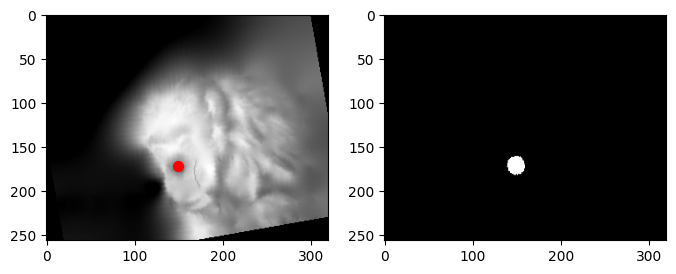

In [38]:
#To test that the mask and image do match visually:

#first batch
train_batch = next(iter(train_loader))  

#one image, mask
img, mask = train_batch[0][0], train_batch[1][0]

#Convert tensors to numpy format for visualization
img = img.permute(1, 2, 0).numpy()  #Convert from (C, H, W) -> (H, W, C)
mask = mask.squeeze().numpy()  #Convert from (1, H, W) -> (H, W)
centroid = calculate_centroid(mask)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img, cmap="gray")
ax[0].scatter(centroid[1], centroid[0], color="red", s=50, label="Nose Centroid")
ax[1].imshow(mask, cmap="gray")
plt.show()

# Building Network/Architecture

In [8]:
#We are using a U-net model which is best for segmentation tasks
#But making use of pre-trained encoder
#Only find pre-trained encoders because they act as "feature extractor"
#Know what are important feature to extract (e.g. learnt about edges, and circles, ect.)
#But decoder is about reconstructing your image, and so must be specific to your data

model = smp.Unet(
    encoder_name="resnet18",  #Or "resnet18" encoder
    encoder_weights="imagenet",  #Use pretrained weights
    in_channels=3, #copying 3 grayscale images  
    classes=1,  #Binary segmentation: nose or not 
    activation=None )  #Output doesn't require sigmoid since cross-binary Entropy loss function
    #uses sigmoid already
# decoder follows a standard U-Net design

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [40]:
model.to(device)
summary(model, input_size=(1, 3, 256, 320)) 

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 1, 256, 320]          --
├─ResNetEncoder: 1-1                          [1, 3, 256, 320]          --
│    └─Conv2d: 2-1                            [1, 64, 128, 160]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 160]         128
│    └─ReLU: 2-3                              [1, 64, 128, 160]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 80]           --
│    └─Sequential: 2-5                        [1, 64, 64, 80]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 80]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 80]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 40]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 40]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 40]          295,42

# Training

# Different losses

In [41]:
#Dice loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        #Convert logits to probabilities
        pred = torch.sigmoid(pred)  
        #Compute overlap
        intersection = (pred * target).sum(dim=(1, 2, 3))
        #Compute total pixels
        union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))  
        #Dice coefficient
        dice = (2. * intersection + self.smooth) / (union + self.smooth)  
        return 1 - dice.mean()  # Dice Loss


In [24]:
#Binary Cross Entropy + Dice Loss
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5, smooth=1e-6):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss(smooth)

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.weight * bce_loss + (1 - self.weight) * dice_loss



# Different Criterions used

In [28]:
#Criterion #1
#criterion = nn.BCEWithLogitsLoss()
#Binary Cross Entropy (BCE) with a built-in sigmoid activation function
#During training it takes in raw logits (-3.2, 0.5, ect) and applies sigmoid function
#Which will change their values to range from 0-1 (probabilites)
#So it's saying for each pixel what is the probability
#It is a nose vs not
#This is why not activation function was applied above
#but for evaluation will need 0.5 threshold for white vs black

#optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4) 
#Learning rate: 0.0001
#ADAM; has adaptive learning rates

In [42]:
#Round 2
# Set the criterion to Dice Loss
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4) 
#This was the chosen loss

In [20]:
#round 3: Hybrid
#e.g. weight of 0.2 means 0.2 for BCE
#criterion = BCEDiceLoss(weight=0.8)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# Different Metrics

In [43]:
#Metric: IOU is intersection over union
#How much do the segmentation masks match?
#Here we are applying 0.5 threshold for white and below will be black 

def iou_metric(outputs, labels, threshold=0.5):
    #Converting logits to 0-1/ probabilities
    outputs = torch.sigmoid(outputs)
    #If probability > 0.5 then white, else black
    outputs = (outputs > threshold).float()  
  
    intersection = (outputs * labels).sum(dim=(1, 2, 3)) 
    union = (outputs + labels - outputs * labels).sum(dim=(1, 2, 3))  
    #Stores how many white pixels there should be (labels)
    #that way you can see how much they intersect/ how much there is left

    #If the masks are perfect; union of 0, then you would be dividing by 0
    #to avoid this we automatically say in that case it is perfect segmentation IOU = 1
    iou = torch.where(union > 0, intersection / union, torch.tensor(1.0, device=outputs.device))
    #average IOU for that batch
    return iou.mean().item() 

In [44]:
#Computes the Euclidean distance between the centroids of the predicted and ground truth masks. Returns also how many
#no nose was predicted for (no nose mask/no detection)

def centroid_metric(output, label):
    batch_size, _, H, W = output.shape

    #Convert logits to binary mask (sigmoid + threshold)
    binary_output = (torch.sigmoid(output) > 0.5).float().squeeze(1)  
    binary_label = label.squeeze(1)  # (B, H, W)

    #Why we squeeze:  torch.nonzero on a (1, H, W) tensor would return indices that include the channel dimension, 
    #and you'd have to account for that extra dimension in your calculations. 
    #Squeezing ensures that your functions operate on a simple 2D mask per sample.

    distances = []
    #Count of samples with no white pixels in prediction
    num_missed = 0  

    for i in range(batch_size):
        #Find white pixel coordinates in predicted and ground truth masks
        output_pixels = torch.nonzero(binary_output[i], as_tuple=False)
        #returns a tensor containing the indices of all non-zero (i.e. white) pixels in the mask for the i-th sample
        #as_Tuple = false, means it terutns a 1d Tensors (easier for calculation), than 2d tuple with x and y indices
        label_pixels = torch.nonzero(binary_label[i], as_tuple=False)

        #If no white pixels predicted, skip this sample and count as a miss
        if output_pixels.shape[0] == 0:
            num_missed += 1
            continue

        #If the ground truth has no white pixels, skip as well (or handle as desired)
        if label_pixels.shape[0] == 0:
            continue

        #Compute centroids
        output_cen = output_pixels.float().mean(dim=0) 
        label_cen = label_pixels.float().mean(dim=0)      

        #Compute Euclidean distance between centroids
        dist = torch.norm(output_cen - label_cen, p=2).item()
        distances.append(dist)

    if distances:
        mean_distance = sum(distances) / len(distances)
    else:
        mean_distance = None 

    return mean_distance, num_missed


# Training U-Net

In [45]:
num_epochs = 150
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0
min_delta = 1e-4

train_losses = []
val_losses = []
train_ious = []
val_ious = []

#Average centroid distance over valid samples per epoch
train_distances = [] 
val_distances = []
#Total number of missed predictions per epoch (train)
train_missed = []     
val_missed = []       

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    #Count of missed detection and centroid distance
    running_distance_sum = 0.0  
    running_valid_count = 0  
    running_missed = 0      
    
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        #compute loss and IoU normally
        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        running_iou += iou_metric(outputs, masks) * batch_size

        #compute the new centroid metric (returns a tuple: (mean_distance, num_missed) )
        batch_mean_distance, batch_missed = centroid_metric(outputs, masks)
        valid_count = batch_size - batch_missed  # valid predictions in this batch
        
        #only add distance if there are valid predictions
        if valid_count > 0 and batch_mean_distance is not None:
            running_distance_sum += batch_mean_distance * valid_count
            running_valid_count += valid_count
        
        running_missed += batch_missed

    #Compute average training metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = running_iou / len(train_loader.dataset)
    #average centroid distance computed only over valid predictions
    epoch_distance = running_distance_sum / running_valid_count if running_valid_count > 0 else 0.0

    train_losses.append(epoch_loss)
    train_ious.append(epoch_iou)
    train_distances.append(epoch_distance)
    train_missed.append(running_missed)

    #validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_distance_sum = 0.0  
    val_valid_count = 0  
    val_missed_count = 0  

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)

            loss = criterion(outputs, masks)
            batch_size = imgs.size(0)
            val_loss += loss.item() * batch_size
            val_iou += iou_metric(outputs, masks) * batch_size

            batch_mean_distance, batch_missed = centroid_metric(outputs, masks)
            valid_count = batch_size - batch_missed
            if valid_count > 0 and batch_mean_distance is not None:
                val_distance_sum += batch_mean_distance * valid_count
                val_valid_count += valid_count

            val_missed_count += batch_missed

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_iou = val_iou / len(val_loader.dataset)
    epoch_val_distance = val_distance_sum / val_valid_count if val_valid_count > 0 else 0.0

    val_losses.append(epoch_val_loss)
    val_ious.append(epoch_val_iou)
    val_distances.append(epoch_val_distance)
    val_missed.append(val_missed_count)

    #report training status
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Train IoU: {epoch_iou:.4f}, Val IoU: {epoch_val_iou:.4f}, "
          f"Train Distance: {epoch_distance:.2f} pixels (missed: {running_missed}), "
          f"Val Distance: {epoch_val_distance:.2f} pixels (missed: {val_missed_count})")
    
    #early Stopping Check: Monitor validation loss
    if best_val_loss - epoch_val_loss > min_delta:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'Model_G_REDONE.pth')
        print("New best validation loss. Model saved.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")
    
    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/150: Train Loss: 0.9798, Val Loss: 0.9550, Train IoU: 0.0254, Val IoU: 0.1088, Train Distance: 48.61 pixels (missed: 0), Val Distance: 52.06 pixels (missed: 0)
New best validation loss. Model saved.
Epoch 2/150: Train Loss: 0.9236, Val Loss: 0.8547, Train IoU: 0.1230, Val IoU: 0.1619, Train Distance: 56.88 pixels (missed: 1), Val Distance: 63.88 pixels (missed: 0)
New best validation loss. Model saved.
Epoch 3/150: Train Loss: 0.8484, Val Loss: 0.9315, Train IoU: 0.1860, Val IoU: 0.0687, Train Distance: 53.31 pixels (missed: 3), Val Distance: 57.34 pixels (missed: 0)
No improvement for 1 epoch(s).
Epoch 4/150: Train Loss: 0.7903, Val Loss: 0.7342, Train IoU: 0.2450, Val IoU: 0.2753, Train Distance: 38.95 pixels (missed: 0), Val Distance: 43.05 pixels (missed: 0)
New best validation loss. Model saved.
Epoch 5/150: Train Loss: 0.7150, Val Loss: 0.6491, Train IoU: 0.2967, Val IoU: 0.3382, Train Distance: 39.01 pixels (missed: 2), Val Distance: 34.11 pixels (missed: 0)
New best val

KeyboardInterrupt: 

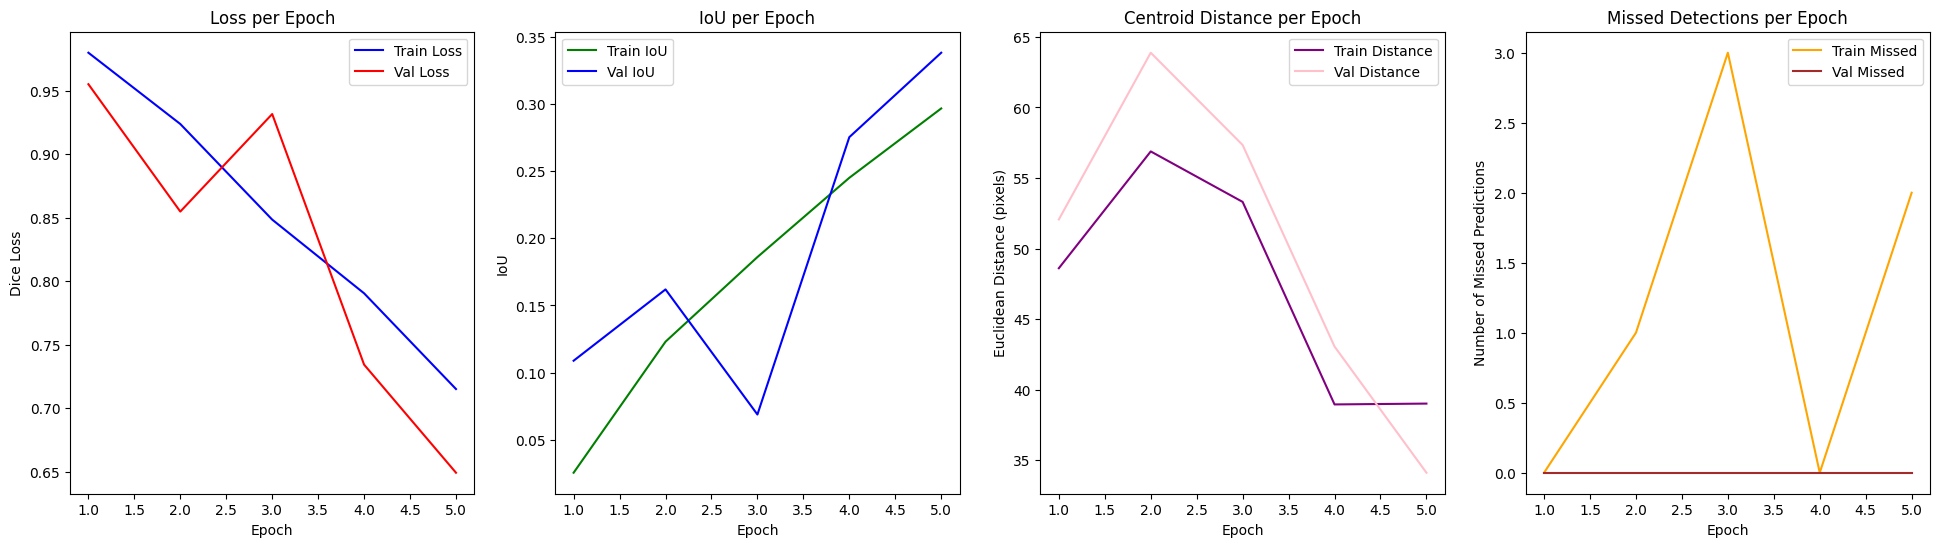

In [46]:
#Displaying training
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(24, 6)) 

#plot Loss per Epoch
plt.subplot(1, 4, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Loss per Epoch')
plt.legend()

#plot IoU per Epoch
plt.subplot(1, 4, 2)
plt.plot(epochs_range, train_ious, label='Train IoU', color='green')
plt.plot(epochs_range, val_ious, label='Val IoU', color='blue')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

#plot Euclidean Centroid Distance per Epoch
plt.subplot(1, 4, 3)
plt.plot(epochs_range, train_distances, label='Train Distance', color='purple')
plt.plot(epochs_range, val_distances, label='Val Distance', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Euclidean Distance (pixels)')
plt.title('Centroid Distance per Epoch')
plt.legend()

#plot Missed Predictions per Epoch (for recall/detection)
plt.subplot(1, 4, 4)
plt.plot(epochs_range, train_missed, label='Train Missed', color='orange')
plt.plot(epochs_range, val_missed, label='Val Missed', color='brown')
plt.xlabel('Epoch')
plt.ylabel('Number of Missed Predictions')
plt.title('Missed Detections per Epoch')
plt.legend()

plt.savefig("training_results.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [23]:
#Saving the model's state dictionary
#weights but not architecture
#not done with early stopping at it saves only the model with the best validation loss
#torch.save(model.state_dict(), "model_F_18_BDIC.pth")


# Testing

In [9]:
#Loading the model
#model.load_state_dict(torch.load("/kaggle/input/model-a-18/model_A_18.pth"))
#summary(model, input_size=(1, 3, 256, 256)) 
#model.to(device)

device = torch.device("cpu")

#Load model with CPU not GPU
model.load_state_dict(torch.load("Model_best.pth", map_location=device))

#Using CPU
model.to(device)

summary(model, input_size=(1, 3, 256, 256))


/tmp/ipykernel_31/3758654387.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/final-model/Model_F.pth", map_location=devic

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 1, 256, 256]          --
├─ResNetEncoder: 1-1                          [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]          295,42

In [10]:
#Centroid calculation for testing (no need to say how many detections missed like before)
def calculate_centroid(binary_image):
    #Find all white pixel coordinates (where value is 255)
    white_pixels = np.column_stack(np.where(binary_image == 255))
    
    if white_pixels.shape[0] == 0:
        white_pixels = None
    
    #Compute centroid
    y_cen, x_cen = np.mean(white_pixels, axis=0)
    return (round(y_cen), round(x_cen))  

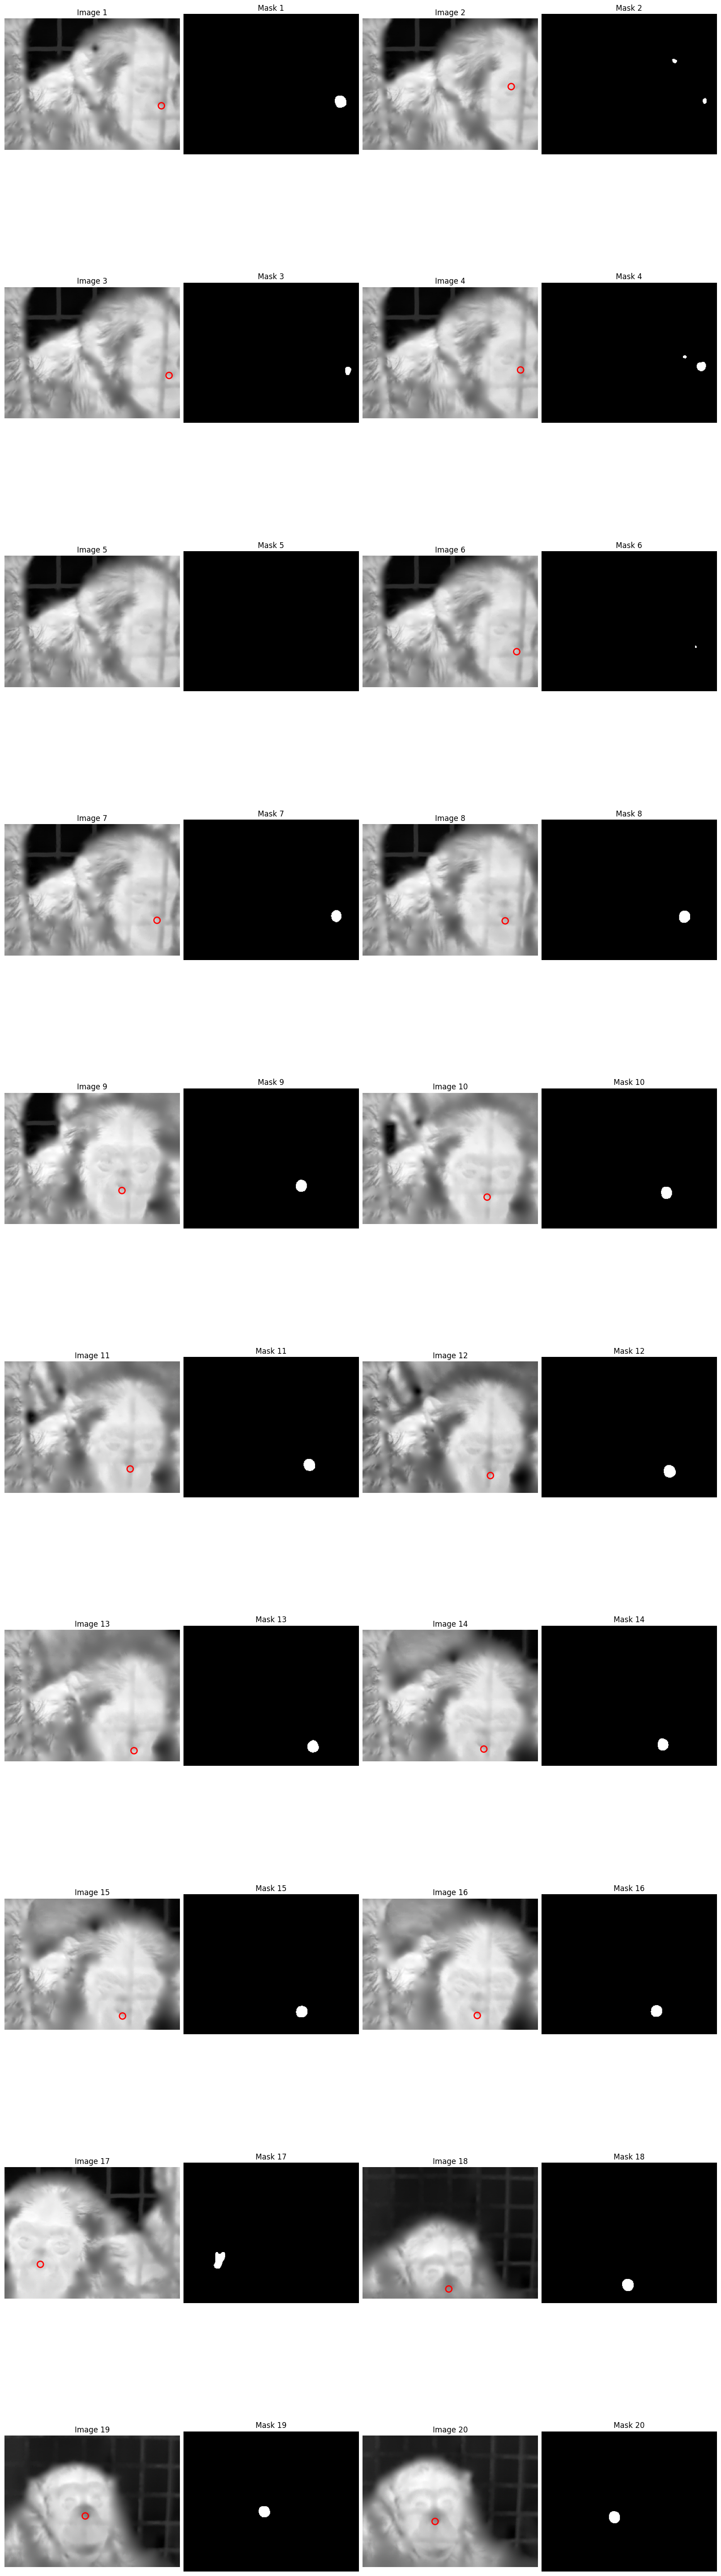

In [11]:
#Qualitative Analysis (displaying frames with there predicted noses in red)
#Evaluation mode
model.eval()
#test folder
test_folder = "/kaggle/input/qualitative-test/test_images_kaggle"
image_paths = sorted(glob.glob(os.path.join(test_folder, "*.png")))  
num_images = len(image_paths)

#Only 2 images per row
images_per_row = 2
rows = math.ceil(num_images / images_per_row)

#2 images => 4 subplots wide. Here we pick (width=16, height=rows*6) as an example
fig, axes = plt.subplots(rows, images_per_row * 2, figsize=(16, rows * 6), constrained_layout=True)
if rows == 1:
    axes = np.array([axes])

for idx, img_path in enumerate(image_paths):
    test_img = Image.open(img_path)
    
    #Preprocess frames for model
    test_img_transformed = base_transform(test_img, is_mask=False)
    test_img_transformed = test_img_transformed.unsqueeze(0).to(device)

    #Run model at inference
    model.eval()
    with torch.no_grad():
        output = model(test_img_transformed)
        output = torch.sigmoid(output)
        output = output.squeeze(0).cpu().numpy()
        output = (output > 0.5).astype(np.uint8) * 255

    output = output.squeeze(0)  # remove extra channel if present

    row_idx = idx // images_per_row
    col_idx = (idx % images_per_row) * 2

    #Show the original image
    axes[row_idx, col_idx].imshow(test_img, cmap='gray')
    axes[row_idx, col_idx].set_title(f"Image {idx+1}")
    axes[row_idx, col_idx].axis("off")

    #If mask has white pixels, draw centroid as an outline circle
    if np.any(output > 0):
        try:
            cy, cx = calculate_centroid(output)  
            axes[row_idx, col_idx].scatter(
                cx, cy, 
                marker='o', 
                s=100, 
                facecolors='none',  
                edgecolors='red', 
                linewidths=2
            )
        except ValueError:
            pass

    #Show the predicted mask
    axes[row_idx, col_idx + 1].imshow(output, cmap='gray')
    axes[row_idx, col_idx + 1].set_title(f"Mask {idx+1}")
    axes[row_idx, col_idx + 1].axis("off")

total_slots = rows * images_per_row * 2
for i in range(num_images * 2, total_slots):
    r_del = i // (images_per_row * 2)
    c_del = i % (images_per_row * 2)
    fig.delaxes(axes[r_del, c_del])

plt.show()
